## 인공지능 기초

##### 202020986 이승진 

간단한 컨볼루션 신경망(CNN)을 사용하여 이미지 분류 작업을 수행합니다. 이 과제에서는 Fashion-MNIST 데이터셋을 사용합니다. Pytorch로 구현

<hr/>

데이터 분석:   
torchvision module에서 제공하는 FashionMNIST를 활용해야 합니다 (전체 데이터)
이미지 데이터의 형태와 클래스 레이블을 시각적으로 탐색하고 분석합니다.


모델 구축 및 훈련:   
간단한 CNN 모델을 구축합니다. 모델은 적어도 한 개의 컨볼루션 레이어와 풀링 레이어를 포함해야 합니다.
모델을 컴파일하고, 적절한 손실 함수와 최적화 알고리즘을 선택합니다.
훈련 데이터를 사용하여 모델을 훈련시키고, 훈련 과정에서의 손실과 정확도를 모니터링합니다.


모델 평가 및 결과 분석:   
테스트 데이터셋을 사용하여 모델을 평가하고, 최종 정확도를 보고합니다.
잘못 분류된 이미지들을 분석하고, 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별합니다.

<hr/>


#### 사용되는 모듈을 다운합니다.

In [1]:
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### FashionMNIST 데이터 로드, 클래스별 탐색


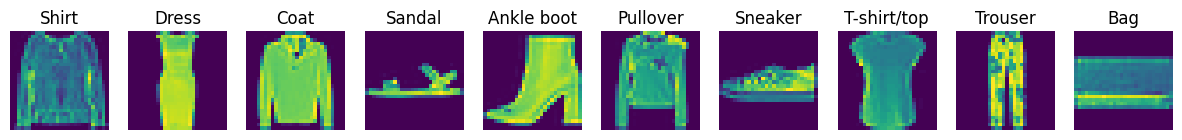

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# FashionMNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# FashionMNIST 클래스 레이블
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# FashionMNIST 데이터셋에서 카테고리별 하나씩 이미지 시각화
def show_fashion_mnist_samples(trainloader, classes):
    # 각 클래스 별로 하나씩 이미지 가져오기
    sample_images = {}
    for data in trainloader:
        images, labels = data
        for image, label in zip(images, labels):
            label_index = label.item()
            if label_index not in sample_images:
                sample_images[label_index] = image
            if len(sample_images) == len(classes):  # 모든 클래스의 이미지를 가져왔으면 종료
                break
        else:
            continue
        break

    # 이미지 시각화
    fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
    for i, label_index in enumerate(sample_images.keys()):
        image = sample_images[label_index]
        image = image / 2 + 0.5  # 이미지의 정규화 해제
        np_image = image.numpy()
        np_image = np.transpose(np_image, (1, 2, 0))  # 이미지 차원 변경 (C, H, W) -> (H, W, C)
        axs[i].imshow(np_image.squeeze())
        axs[i].set_title(classes[label_index])
        axs[i].axis('off')
    plt.show()

# 시각화 함수 호출
show_fashion_mnist_samples(trainloader, classes)

# Shirt, T-shirt/top
# Sneaker, Sandal, Ankel boot
# Pullover, Coat
# Trouser, Dress
# 위 4개의 그룹의 구분이 쉽지 않다
# 하지만 Bag은 고유의 모양이 있어 Bag만은 구분이 쉬울 듯 하다


##### 클래스의 데이터 수가 동일한 것을 알 수 있다

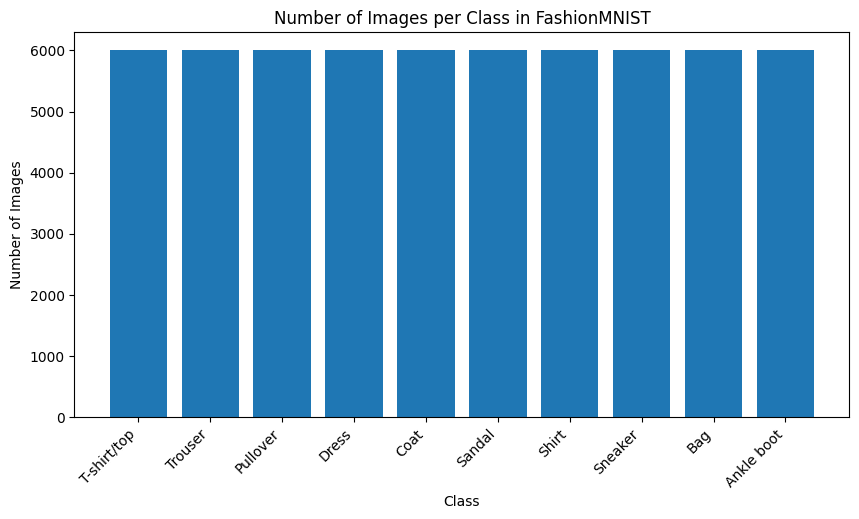

In [3]:
# 각 클래스별 데이터 수 계산
class_counts = {}
for _, labels in trainloader:
    for label in labels:
        label_index = label.item()
        class_counts[label_index] = class_counts.get(label_index, 0) + 1

# 데이터 수를 시각화
plt.figure(figsize=(10, 5))
plt.bar(classes, [class_counts[i] for i in range(len(classes))])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in FashionMNIST')
plt.xticks(rotation=45, ha='right')
plt.show()

##### CNN 모델 정의
1. 모델은 두 개의 합성곱 레이어(Conv2d), 두 개의 최대 풀링 레이어(MaxPool2d), 그리고 두 개의 완전 연결 레이어(Linear)로 구성됩니다.
2. CrossEntropyLoss를 손실 함수로, Adam을 옵티마이저로 사용하여 모델을 초기화합니다.
3. 각 에폭마다 데이터를 반복하고, 옵티마이저를 사용하여 모델을 업데이트합니다.

Epoch 1, Loss: 0.486, Accuracy: 82.21%
Epoch 2, Loss: 0.312, Accuracy: 88.52%
Epoch 3, Loss: 0.266, Accuracy: 90.25%
Epoch 4, Loss: 0.233, Accuracy: 91.36%
Epoch 5, Loss: 0.205, Accuracy: 92.41%


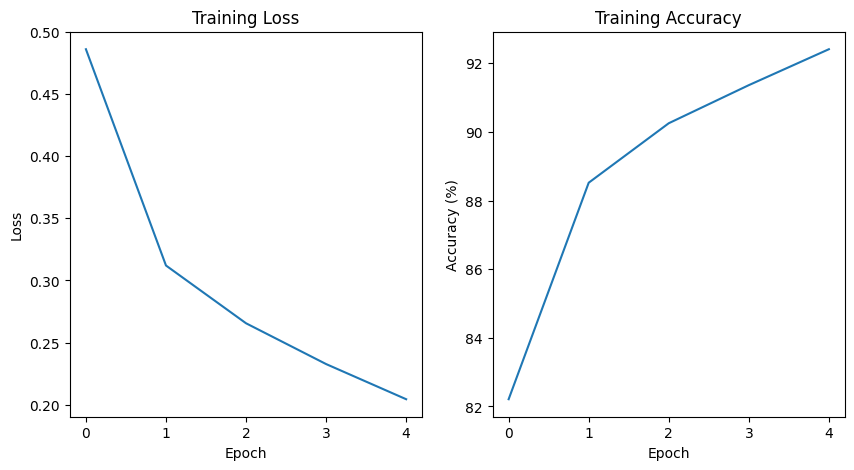

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 생성 및 손실 함수 및 옵티마이저 정의
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련 및 손실과 정확도 기록
losses = []
accuracies = []

for epoch in range(5):  # 5 epochs
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%")

# 손실과 정확도 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')

plt.show()

##### 테스트 데이터셋 로드, 모델 평가

In [5]:
# FashionMNIST 테스트 데이터셋 로드
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 모델 평가
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 90.87%


##### 잘못 분류된 이미지 시각화
1. Shirt, T-shirt/top     
2. Sneaker, Sandal, Ankel boot     
3. Pullover, Coat     
4. Trouser, Dress    
위 4개의 그룹의 구분이 쉽지 않다

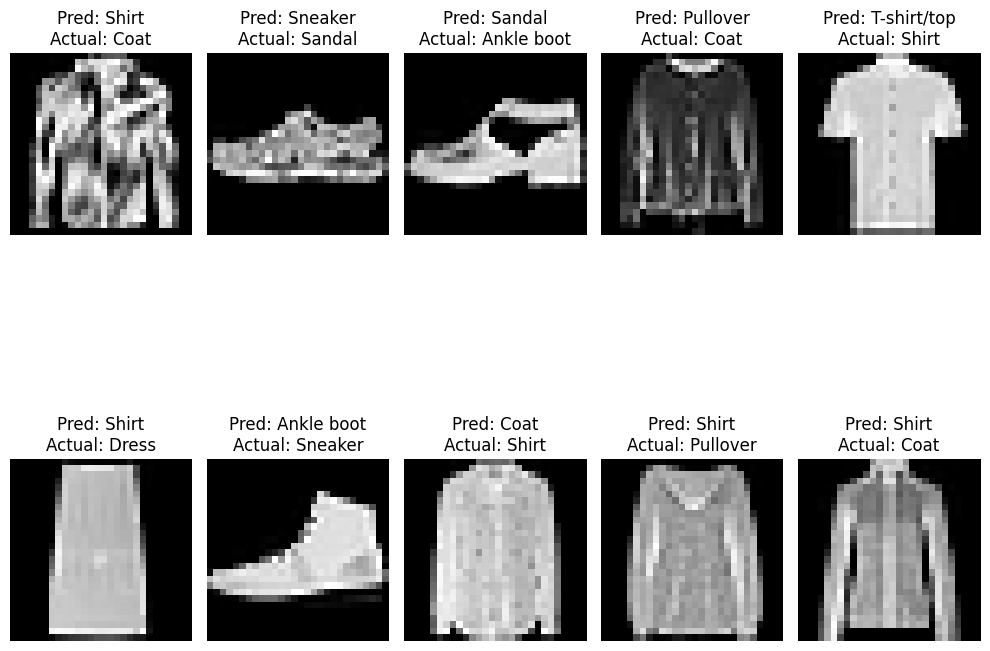

In [11]:
import numpy as np

class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# 테스트 데이터셋에서 모델의 예측 가져오기
model.eval()
misclassified_images = []
misclassified_labels = []
correct_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        misclassified_inds = (predicted != labels).nonzero()[:, 0]
        misclassified_images.extend(images[misclassified_inds])
        misclassified_labels.extend(predicted[misclassified_inds])
        correct_labels.extend(labels[misclassified_inds])

# 잘못 분류된 이미지 시각화
plt.figure(figsize=(10, 10))
for i, misclassified_label in enumerate(misclassified_labels[:10]):  # 최대 10개의 subplot만 사용
    plt.subplot(2, 5, i + 1)
    misclassified_image = misclassified_images[i].squeeze().numpy()
    plt.imshow(misclassified_image, cmap='gray')
    plt.title(f'Pred: {class_names[misclassified_label.item()]}\nActual: {class_names[correct_labels[i].item()]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


##### 카테고리별 손실도와 정확도 시각화

예상했던대로 Bag의 정확도가 높은 편이다

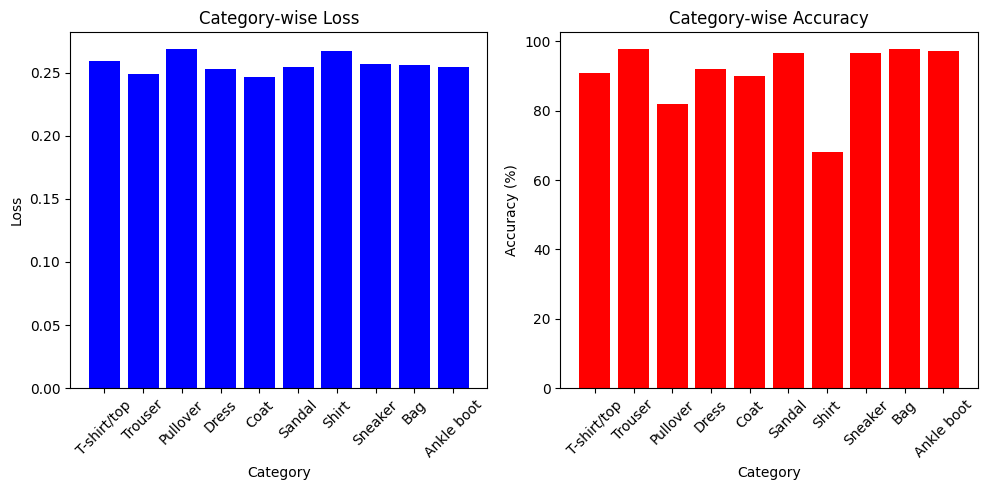

In [10]:
# 카테고리별 손실도와 정확도 계산
category_losses = np.zeros(10)
category_counts = np.zeros(10)
category_correct = np.zeros(10)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels).item()
        for i in range(len(labels)):
            category_losses[labels[i]] += loss
            category_counts[labels[i]] += 1
            if predicted[i] == labels[i]:
                category_correct[labels[i]] += 1

# 손실도와 정확도 시각화
plt.figure(figsize=(10, 5))

# 손실도 그래프
plt.subplot(1, 2, 1)
plt.bar(np.arange(10), category_losses, color='blue')
plt.xlabel('Category')
plt.ylabel('Loss')
plt.title('Category-wise Loss')
plt.xticks(range(10), [class_names[i] for i in range(10)], rotation=45)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.bar(np.arange(10), category_accuracies, color='red')
plt.xlabel('Category')
plt.ylabel('Accuracy (%)')
plt.title('Category-wise Accuracy')
plt.xticks(range(10), [class_names[i] for i in range(10)], rotation=45)

plt.tight_layout()
plt.show()
